In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from sklearn.preprocessing import Normalizer #remove this?
plt.style.use('ggplot')

# Setting up
Lets first read our data and see what we are dealing with. We are going to predict housing prices in King County, WA.

I am going to run some basic checks to see what my data looks like

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
df.columns #looks like we don't have to deal with any importing issues so far

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

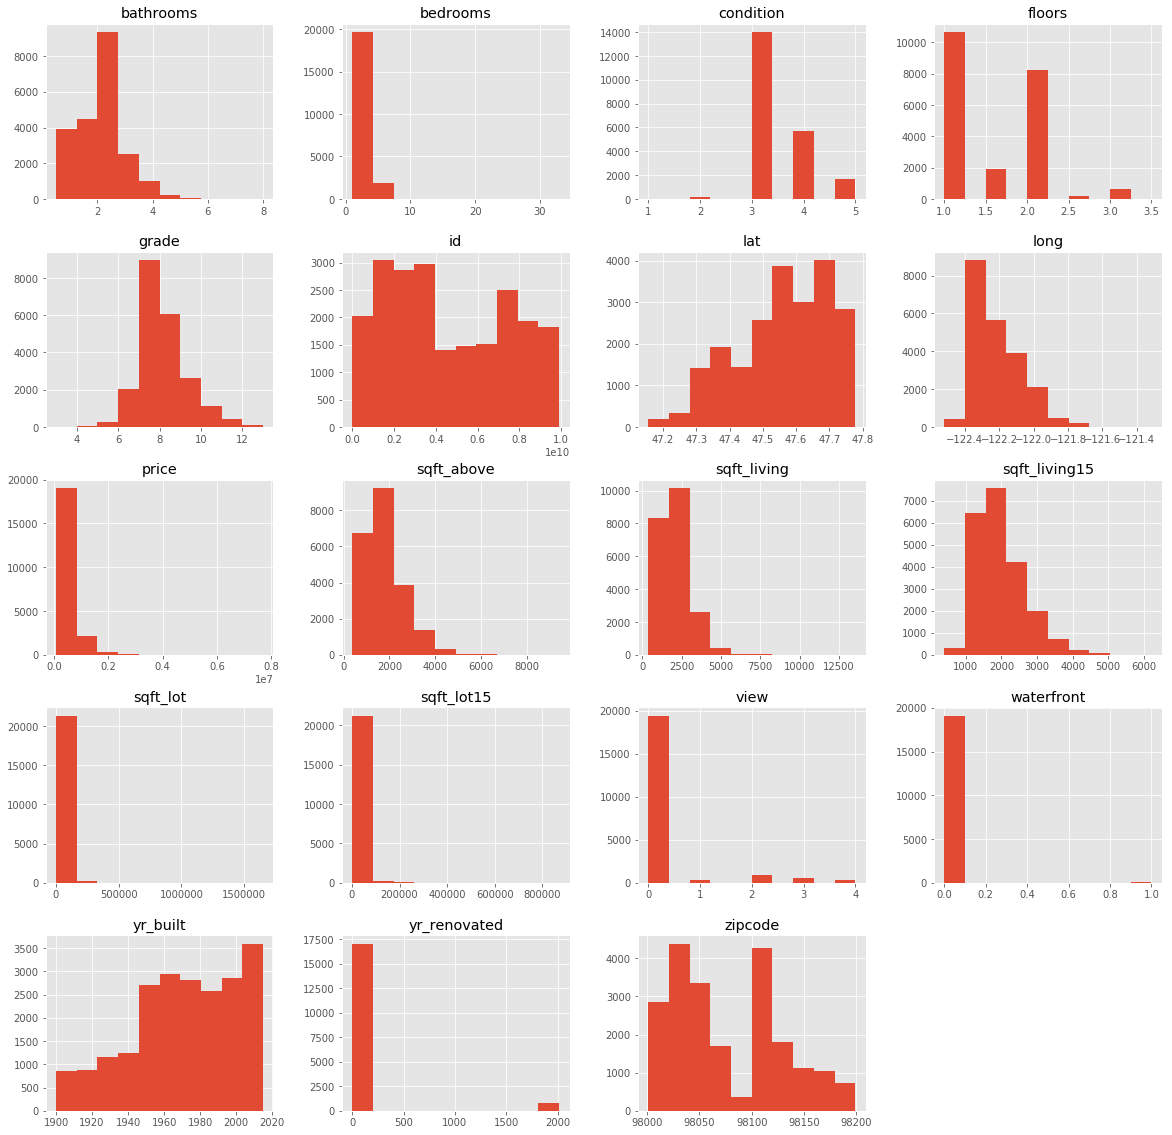

In [4]:
plt.style.use('ggplot')
df.hist(figsize = (20,20)); #checking size and dists

In [5]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


There is a big variation (sigma > mu) in yr_renovated and sqft_lot15. Also extreme values in sqft_lot15, bathrooms, and bedrooms. I have learned that there is some conflicting information about the columns sqft_lot15 and sqft_living15 represent and contain.

I will drop sqft_15s columns along as investigating bathrooms and bathroom's extreme values.

In [6]:
df.drop(['sqft_living15', 'sqft_lot15'],axis=1, inplace=True)

df.bathrooms.nlargest(), df.bedrooms.nlargest()

(7245     8.00
 12764    8.00
 9245     7.75
 8537     7.50
 4020     6.75
 Name: bathrooms, dtype: float64, 15856    33
 8748     11
 13301    10
 15147    10
 19239    10
 Name: bedrooms, dtype: int64)

I will deal with bathroom further down the line since it looks like there is some spread into the higher values. I will delete the property with 33 bedrooms though.

In [7]:
df.drop(15856, inplace=True) #droppping by the index

In [8]:
df.bedrooms.nlargest()

8748     11
13301    10
15147    10
19239    10
4092      9
Name: bedrooms, dtype: int64

### Datatypes

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 19 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null int64
bathrooms        21596 non-null float64
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null float64
waterfront       19220 non-null float64
view             21533 non-null float64
condition        21596 non-null int64
grade            21596 non-null int64
sqft_above       21596 non-null int64
sqft_basement    21596 non-null object
yr_built         21596 non-null int64
yr_renovated     17754 non-null float64
zipcode          21596 non-null int64
lat              21596 non-null float64
long             21596 non-null float64
dtypes: float64(8), int64(9), object(2)
memory usage: 3.3+ MB


Lets make them all the correct data types.

In [10]:
df.sqft_basement = df.sqft_basement.astype('float')

ValueError: could not convert string to float: '?'

It looks like there may be some placeholder in the data.

In [11]:
sum(df.sqft_basement == "?")

454

There are 454 '?' placeholders in the .sqft_basement . I will need to take care of them.

In [12]:
mask = df.sqft_basement == '?' #This sets our condtional situation.
column_name = 'sqft_basement' #what columns we effect with our mask
df.loc[mask, column_name] = 0

#df.loc[df.sqft_basement == '?', 'sqft_basement'] = 0 #Works the same way above.
#I like having options

In [13]:
df.sqft_basement = df.sqft_basement.astype('float64')

Now for the categorical variables

In [14]:
cols = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode']
for col in cols:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 19 columns):
id               21596 non-null int64
date             21596 non-null object
price            21596 non-null float64
bedrooms         21596 non-null category
bathrooms        21596 non-null category
sqft_living      21596 non-null int64
sqft_lot         21596 non-null int64
floors           21596 non-null category
waterfront       19220 non-null category
view             21533 non-null category
condition        21596 non-null category
grade            21596 non-null category
sqft_above       21596 non-null int64
sqft_basement    21596 non-null float64
yr_built         21596 non-null category
yr_renovated     17754 non-null category
zipcode          21596 non-null category
lat              21596 non-null float64
long             21596 non-null float64
dtypes: category(10), float64(4), int64(4), object(1)
memory usage: 1.9+ MB


In [15]:
df.describe() #checking to see if everything looks in order.

,id,price,sqft_living,sqft_lot,sqft_above,sqft_basement,lat,long
count,2.159600e+04,2.159600e+04,21596.000000,2.159600e+04,21596.000000,21596.000000,21596.000000,21596.000000
mean,4.580575e+09,5.402920e+05,2080.343165,1.509983e+04,1788.631506,285.702954,47.560087,-122.213977
std,2.876764e+09,3.673760e+05,918.122038,4.141355e+04,827.763251,439.825454,0.138552,0.140725
min,1.000102e+06,7.800000e+04,370.000000,5.200000e+02,370.000000,0.000000,47.155900,-122.519000
25%,2.123049e+09,3.220000e+05,1430.000000,5.040000e+03,1190.000000,0.000000,47.471100,-122.328000
50%,3.904930e+09,4.500000e+05,1910.000000,7.619000e+03,1560.000000,0.000000,47.571800,-122.231000
75%,7.308950e+09,6.450000e+05,2550.000000,1.068550e+04,2210.000000,550.000000,47.678000,-122.125000
max,9.900000e+09,7.700000e+06,13540.000000,1.651359e+06,9410.000000,4820.000000,47.777600,-121.315000


## TO CLEAN
So we have a mix of catagorical data as well as continious. Our target (price) and a good portion of our sqft data is skewed to the right. We will need to fix that before we run any analysis. Also there are a few varibles that aren't the correct data type.

Need to make dummy variables for the catagories: view, waterfront, condition, floors, zipcode.


Lets check the how random the missing data is using a nifty library [missingno](https://github.com/ResidentMario/missingno).

In [16]:
import missingno as msno

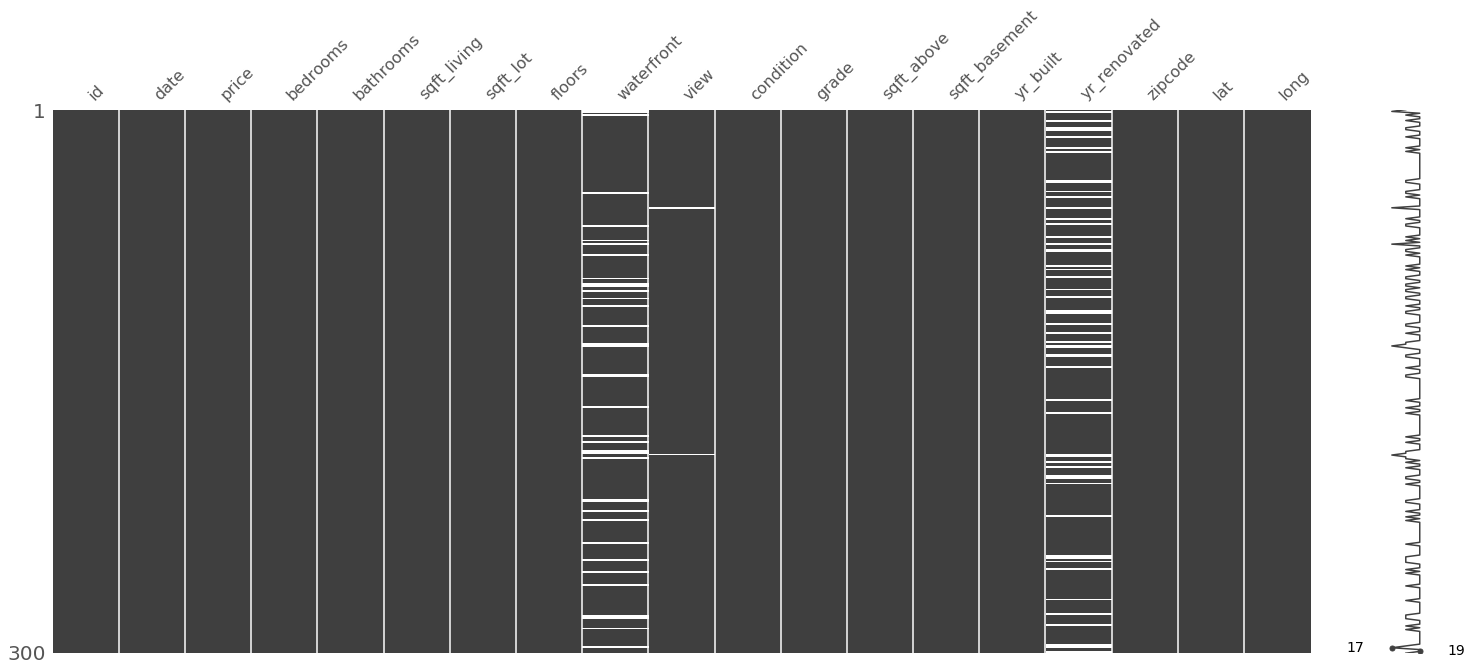

In [17]:
df = df.replace("nan", np.nan) #makes all the nan values into the pandas friendly version. 
msno.matrix(df.sample(300))

So this shows us a sample of our data set and where the data is missing by columns. It looks fairly random where it is missing. That is good.

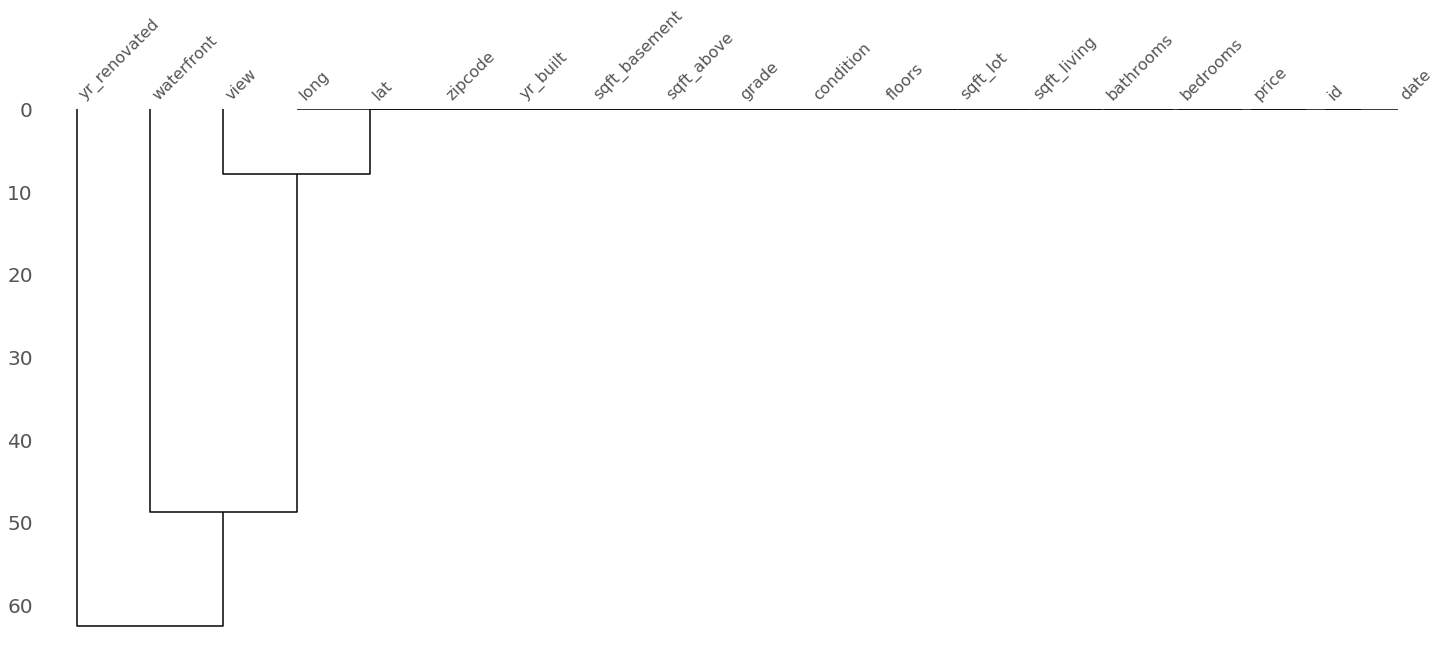

In [18]:
msno.dendrogram(df)

Viewing the dendrogram, we can see that the missing waterfront and yr_renovated do not correspond within their own missing data. We can verify it with the heatmap

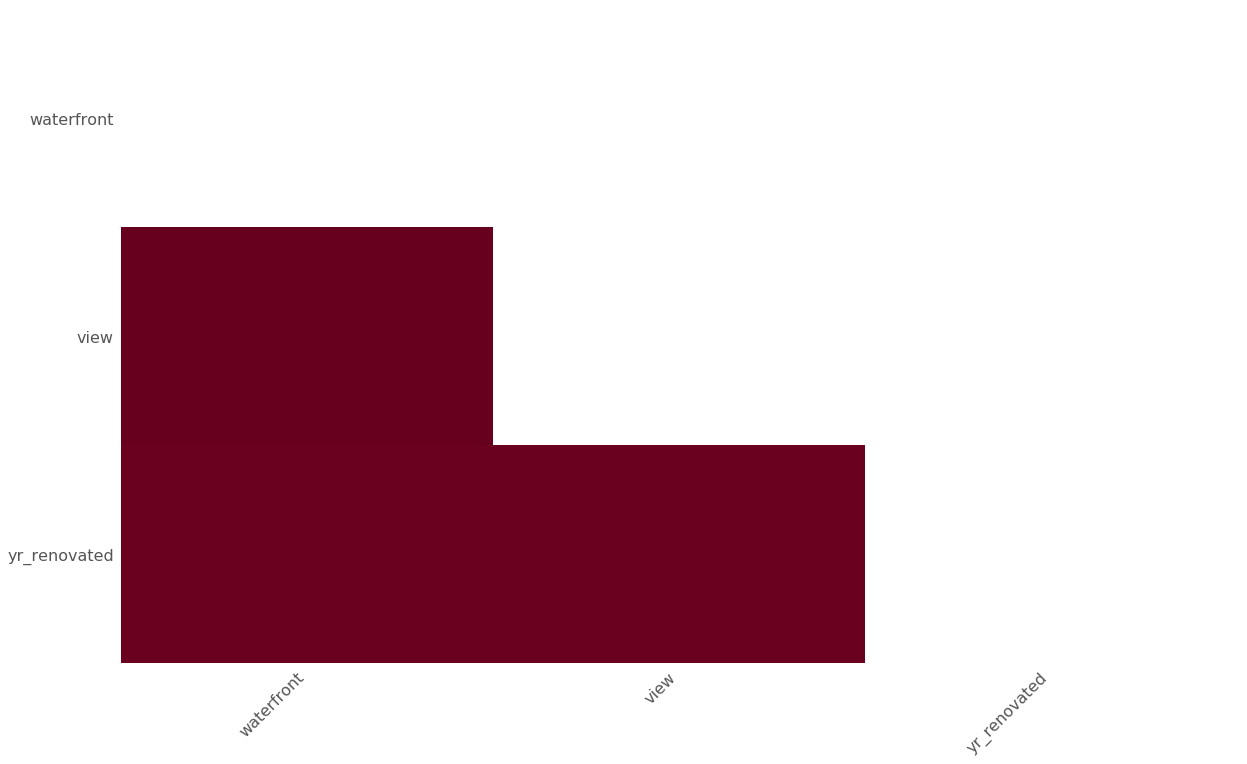

In [19]:
msno.heatmap(df)

Yep, no interaction so don't have to fret about how these values went missing for this set.

So we are grouping this data into relative regions of lat and long by using zip codes, which allows up to check the geographic distribution of the missing data. 

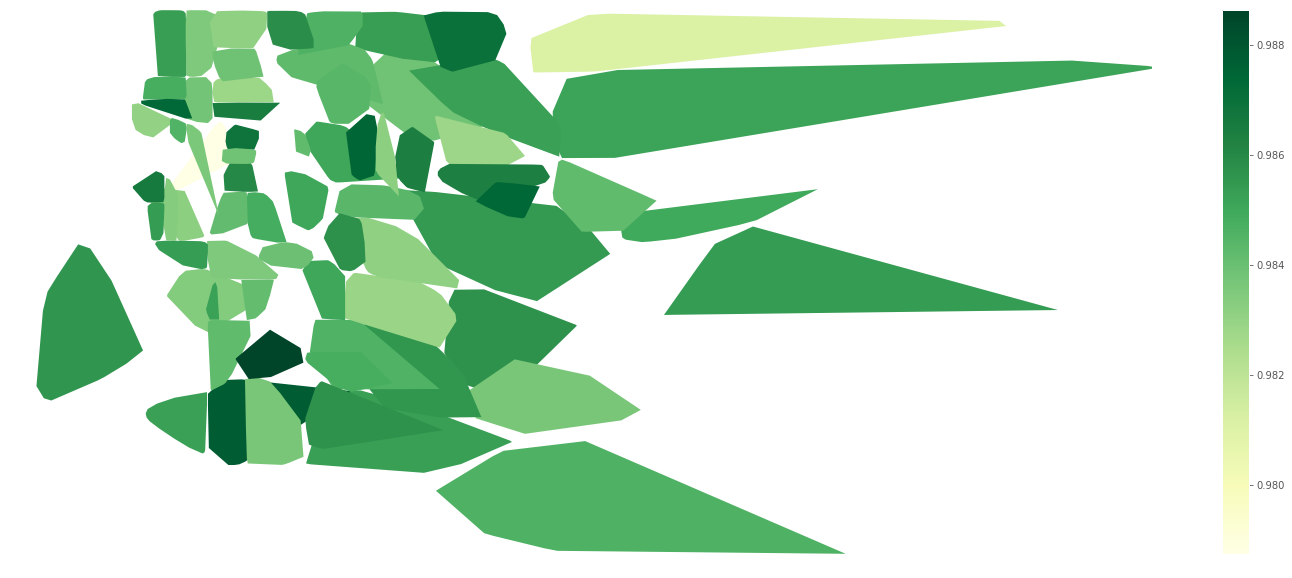

In [20]:
msno.geoplot(df, x='long', y='lat', by='zipcode')

The number of values left blank range by almost 10% and the distances look random enough (there is no disproption in the western rurals areas). **Look at an real map to comparison.** You can kind of see the lake...

In [12]:
import folium
n = folium.Map(
    location = [df.lat.mean(), df.long.mean()])
n

Lets start tackling the empty cells as well as checking for incorrect data types.

In [47]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
dtype: int64

In [29]:
df.waterfront.isna().sum()/len(df)

0.11002037414335988

So 10% of my data for waterfront is missing. I am going to remove that column, along with yr_renovated as well since trying to reconstruct time data without any other kind of supporting information is foolhardy.  

In [30]:
df.drop(['waterfront', 'yr_renovated'], axis=1, inplace=True)

In [31]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
view             63
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
zipcode           0
lat               0
long              0
dtype: int64

---
Now it finally take care of the 63 NaN values in view.

In [32]:
df.view.value_counts()

0.0    19421
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [33]:
df.view.fillna(0, inplace = True) #safely replacing the missing values with zero
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
dtype: int64

In [39]:
df_pred = df.drop(['id', 'date', ], axis=1) #Making a prediction df to check correlation
df_pred.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045


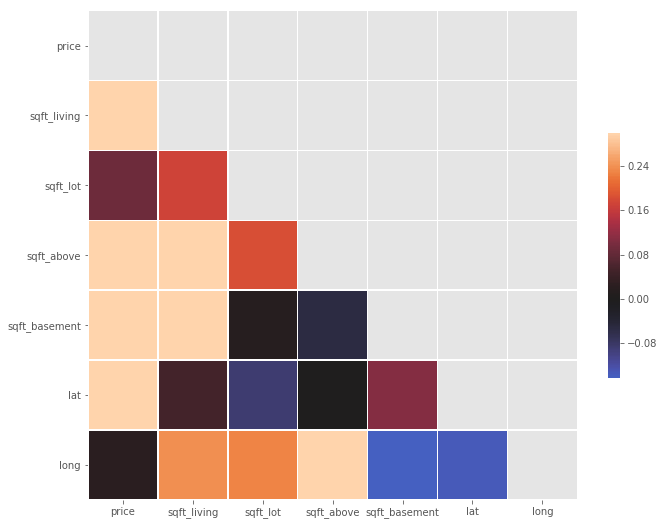

In [40]:
corr = df_pred.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

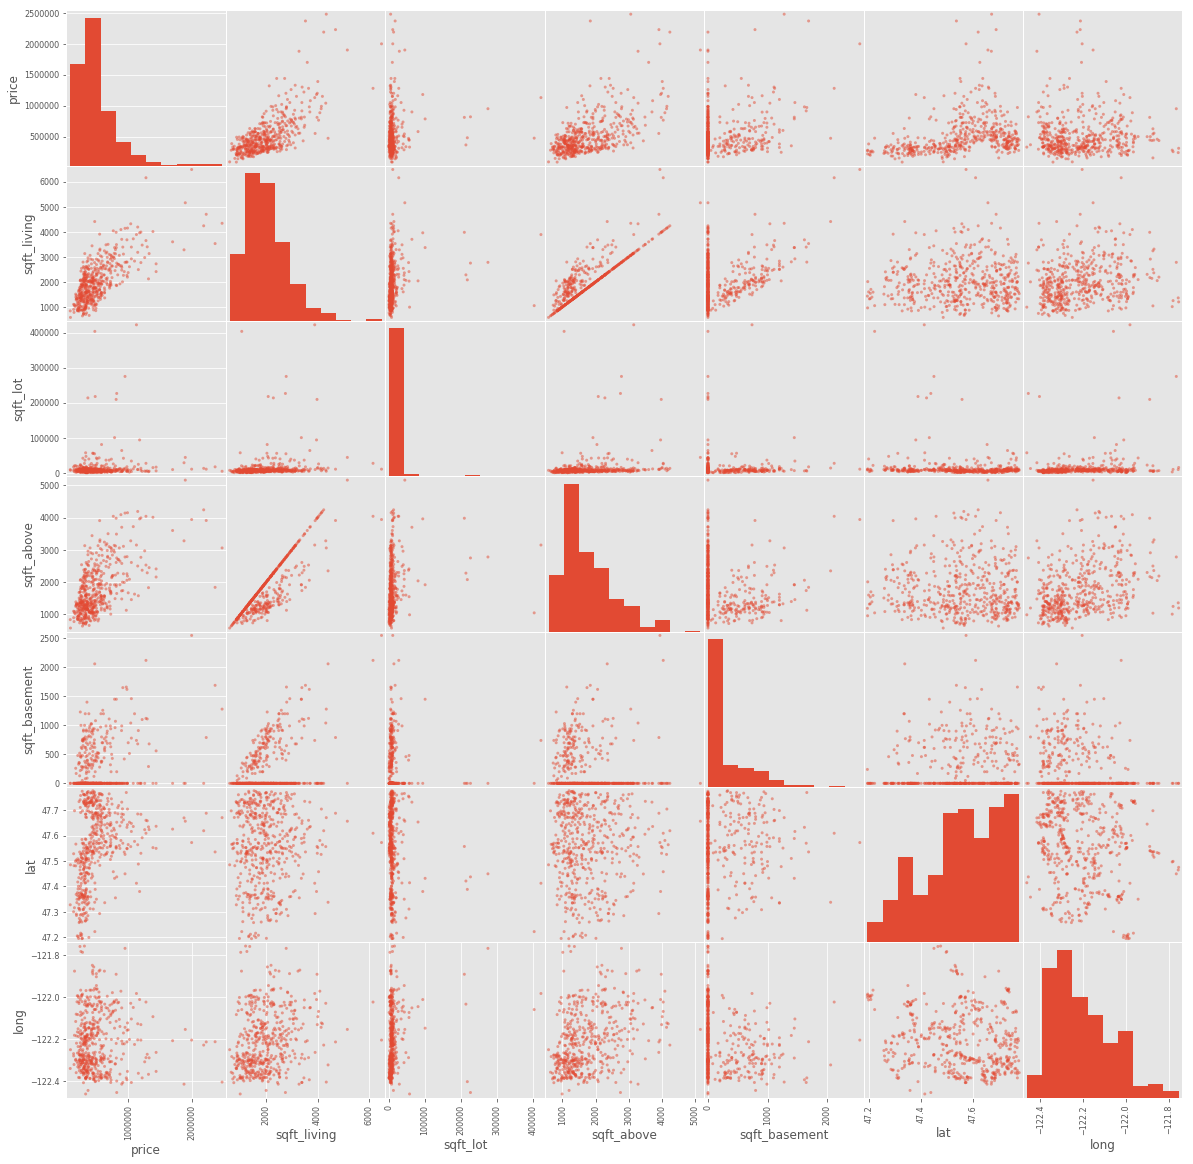

In [41]:
pd.plotting.scatter_matrix(df_pred.sample(500),figsize  = [20, 20]);

---
Looking at this, I am going to combine all the sqfts into one variable. Basement will be hard to unskew due to all those zeroes!

In [42]:
df_pred['sqft_household'] = df_pred.sqft_above + df_pred.sqft_basement + df_pred.sqft_living
df_pred.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_household
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,2360.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,5140.0
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,1540.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,3920.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,3360.0


In [44]:
df_pred.drop(['sqft_above', 'sqft_basement', 'sqft_living'], axis=1, inplace=True)

Now lets recheck the correlation and scatter plots, checking for colinearity.

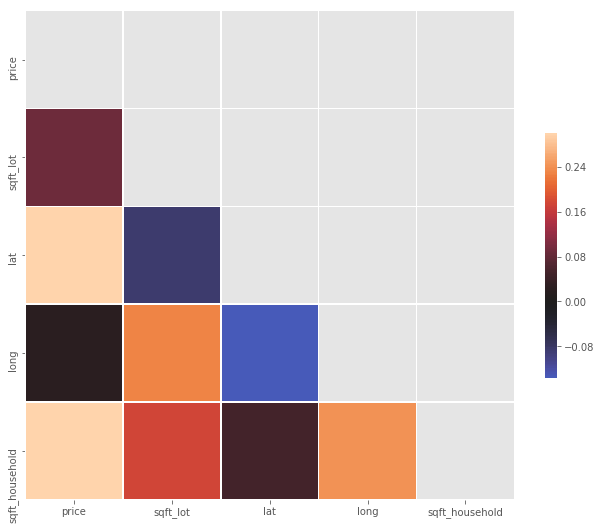

In [45]:
corr = df_pred.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


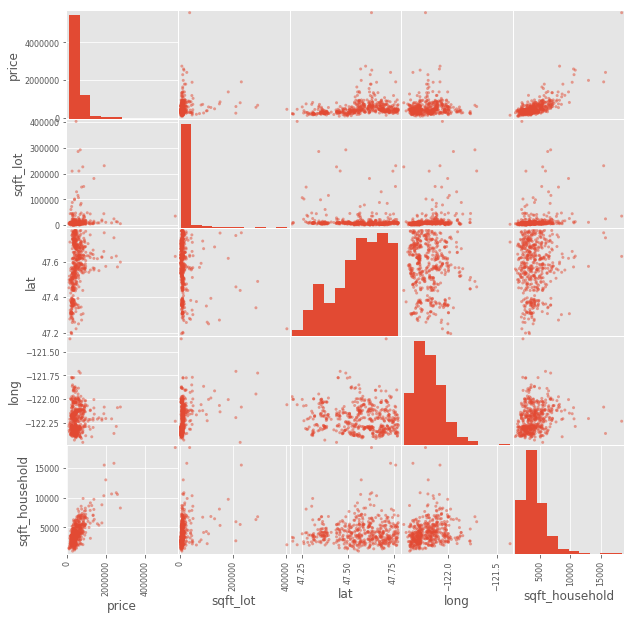

In [47]:
pd.plotting.scatter_matrix(df_pred.sample(500),figsize  = [10, 10]);

In [49]:
df_pred.corr()

,price,sqft_lot,lat,long,sqft_household
price,1.000000,0.089879,0.306687,0.022047,0.701725
sqft_lot,0.089879,1.000000,-0.085507,0.230222,0.173566
lat,0.306687,-0.085507,1.000000,-0.135340,0.051942
long,0.022047,0.230222,-0.135340,1.000000,0.242271
sqft_household,0.701725,0.173566,0.051942,0.242271,1.000000


So it looks like none of the predictors have any real strong correlation between themselves and, logically, sqft strongly correlates with price.

___
---

Next steps are remov

___
---

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018DCDE04748>,
      dtype=object)

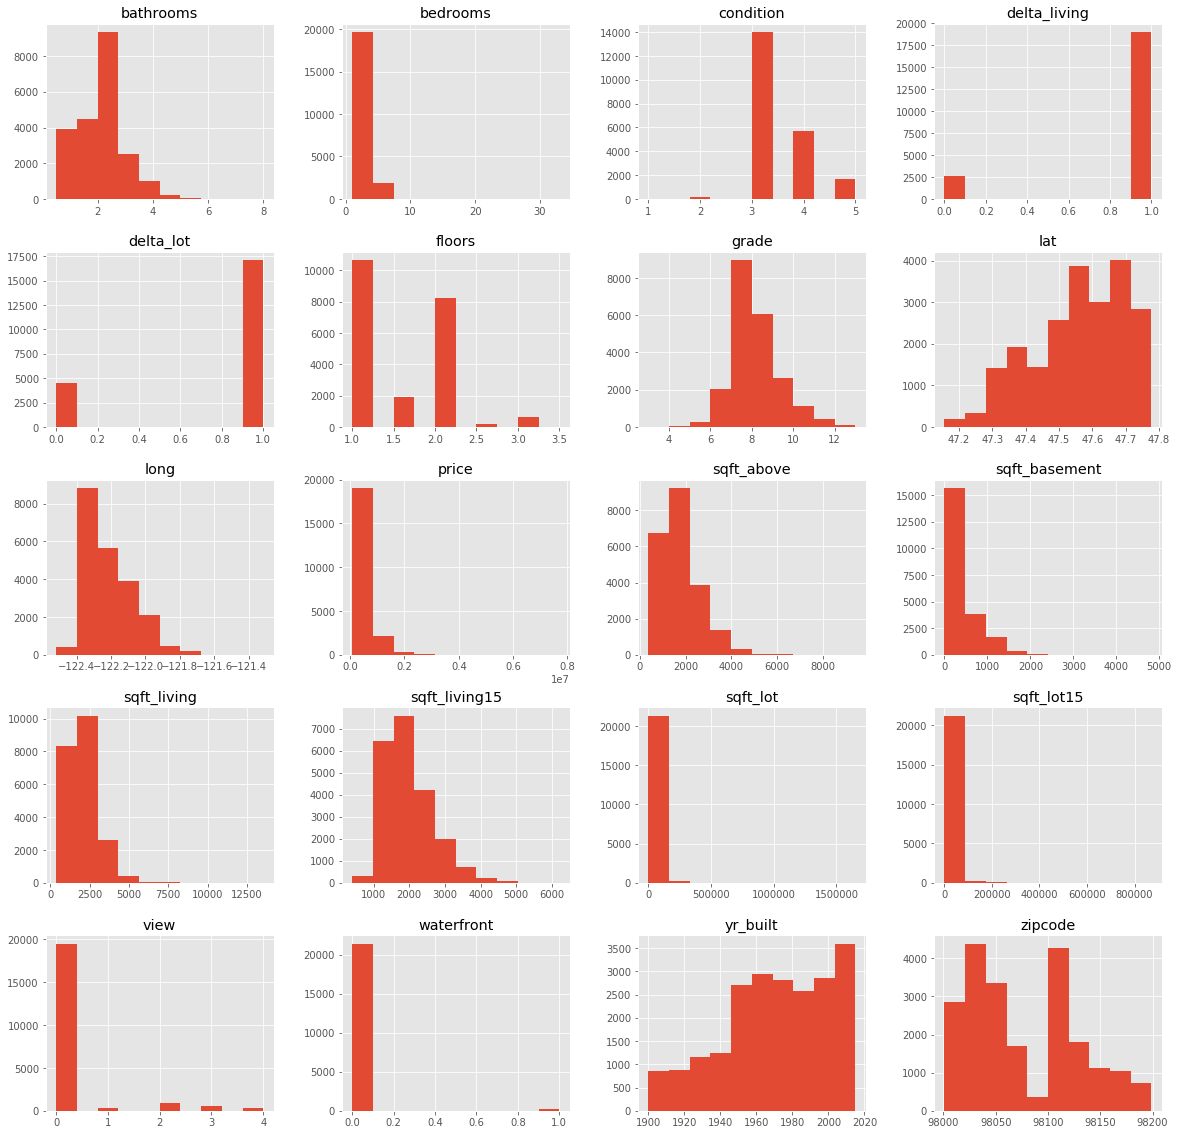

In [97]:
df_pred.hist(figsize=(20,20))

Yep, some cleaning up is required.

In [59]:
log_lot15 = np.log(df_pred.sqft_lot15) #Using the the log transformation to reduce postive skewness
log_above = np.log(df_pred.sqft_above)
#norm_basement = (df_pred.sqft_basement - df_pred.sqft_basement.mean()) / df_pred.sqft_basement.std() 
#I can't find anything that works #Basement has zero in it so we can't use log, we will use something else
log_living = np.log(df_pred.sqft_living)
log_living15 = np.log(df_pred.sqft_living15)
log_lot = np.log(df_pred.sqft_lot)

scaled_lot15 = (log_lot15-np.mean(log_lot15))/np.sqrt(np.var(log_lot15))
scaled_above = (log_above-np.mean(log_above))/np.sqrt(np.var(log_above))
#scaled_basement = (log_basement-np.mean(log_basement))/np.sqrt(np.var(log_basement))
scaled_living = (log_living-np.mean(log_living))/np.sqrt(np.var(log_living))
scaled_living15 = (log_living15-np.mean(log_living15))/np.sqrt(np.var(log_living15))
scaled_lot = (log_lot-np.mean(log_lot))/np.sqrt(np.var(log_lot))


df_pred_scaled = df_pred[['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'zipcode', 'waterfront', 'yr_built', 'grade', 'price']] #adding the catigorical data + target so I can remove the rows concerning outliers
df_pred_scaled['lot15'] = scaled_lot15
df_pred_scaled['above'] = scaled_above
#df_pred_scaled['basement'] = norm_basement
df_pred_scaled['living'] = scaled_living
df_pred_scaled['living15'] = scaled_living15
df_pred_scaled['lot'] = scaled_lot
df_pred_scaled['price'] = np.log(df_pred_scaled.price)

C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018DD1174D30>,
      dtype=object)

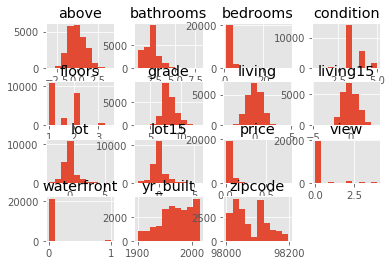

In [60]:
df_pred_scaled.hist()

The cont. variables look good. I got rid of the pesky basement becuase it was unruly and I won't have that kind of behavior in my datasets. Time to remove some outliers, if there are any. Lets check.

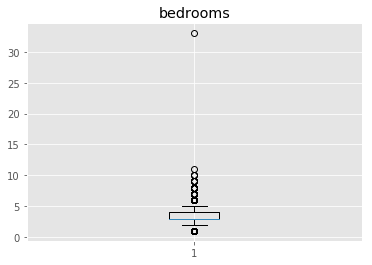

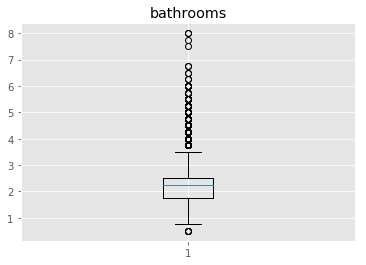

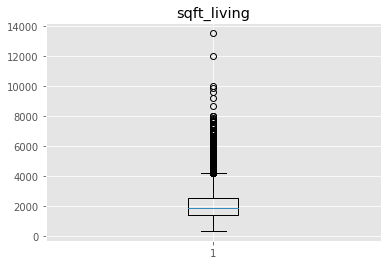

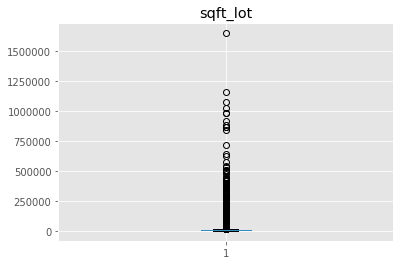

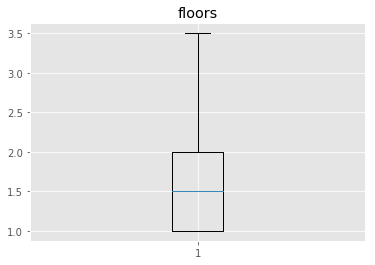

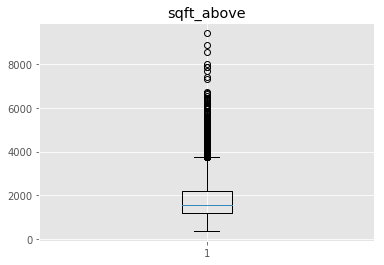

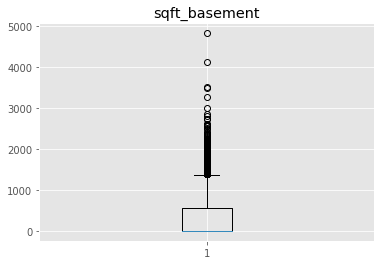

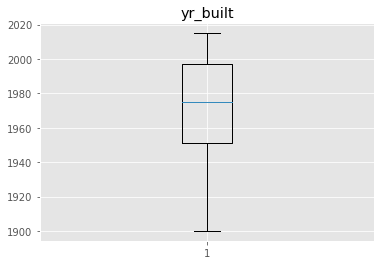

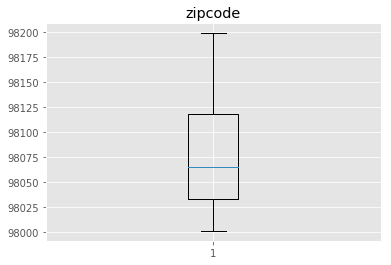

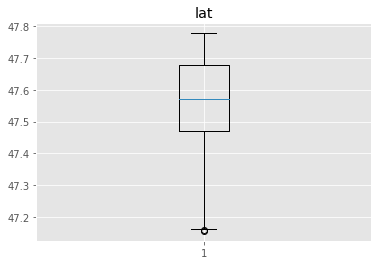

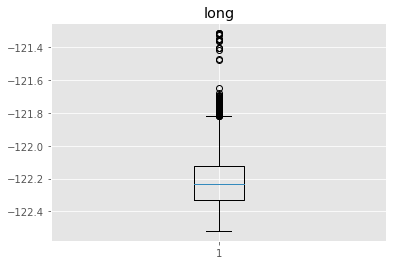

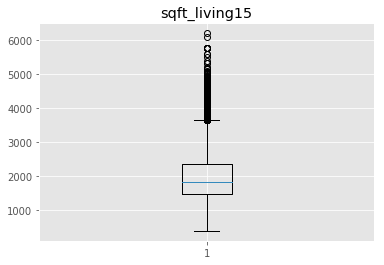

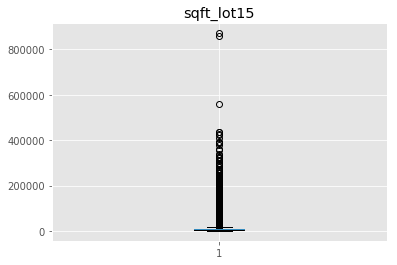

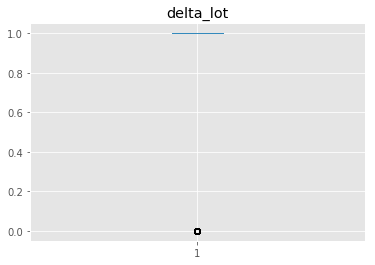

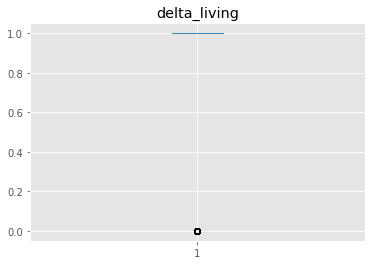

In [98]:
to_plot = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'delta_lot', 'delta_living']
for plot in to_plot:
    plt.boxplot(df_pred[plot])
    plt.title(plot)
    plt.show()

There seems to be a few outliers we have to remove. I will use the IQR to take care of them.

In [99]:
def remove_outlier(df_in, col_names):
    df_out = df_in
    for col in col_names:
        q1 = df_in[col].quantile(0.25)
        q3 = df_in[col].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_in.loc[(df_in[col] > fence_low) & (df_in[col] < fence_high)]
    return df_out

In [100]:
sliming = ['living', 'lot', 'above', 'living15', 'lot15']
df_slim = remove_outlier(df_pred_scaled, sliming)
df_slim.columns, df_slim.shape

(Index(['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'zipcode',
        'waterfront', 'yr_built', 'grade', 'price', 'lot15', 'above', 'living',
        'living15', 'lot'],
       dtype='object'), (19110, 15))

Looks like it did remove some of my outliers. Great. I did forget to normalize my target though. So lets take care of that and now get the dummies for my catagories.

In [101]:
bedroom_dummies = pd.get_dummies(df_slim.bedrooms, prefix="bedroom")
bathroom_dummies = pd.get_dummies(df_slim.bathrooms, prefix='bathrooms')
floors_dummies = pd.get_dummies(df_slim.floors, prefix="floors")
view_dummies = pd.get_dummies(df_slim.view, prefix="view")
condition_dummies = pd.get_dummies(df_slim.condition, prefix="condition")
zipcode_dummies = pd.get_dummies(df_slim.zipcode, prefix="zip")
grade_dummies = pd.get_dummies(df_slim.grade, prefix="grade")
waterfront_dummies = pd.get_dummies(df_slim.waterfront, prefix="waterfront")
yr_built_dummies = pd.get_dummies(df_slim.yr_built, prefix="yr_built")


df_final = pd.concat([df_slim,bedroom_dummies,bathroom_dummies,floors_dummies,view_dummies,condition_dummies,zipcode_dummies,grade_dummies, waterfront_dummies, yr_built_dummies],axis=1)

df_final.drop(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode'], axis=1,inplace=True)

C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Finally need to make them catagorical, my dummies that is.

## Lets try to find our inital model.

I am going to look for an accurate model for our data. This would be used for real estate appraisal in this given area.

In [66]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

y = df_final.price
X = df_final.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) 

In [67]:
from sklearn.linear_model import Lasso

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)

train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test) #This score is R^2
coeff_used001 = np.sum(lasso001.coef_!=0)


In [68]:
train_score001, test_score001 ,coeff_used001

(0.5529353530537937, 0.5494416315417439, 15)

In [69]:

lasso0001 = Lasso(alpha=0.001, max_iter=10e5)
lasso0001.fit(X_train,y_train)

train_score0001=lasso0001.score(X_train,y_train)
test_score0001=lasso0001.score(X_test,y_test) #This score is R^2
coeff_used0001 = np.sum(lasso0001.coef_!=0)

In [70]:
train_score0001, test_score0001 ,coeff_used0001

(0.8627229228058954, 0.8609790470363365, 81)

In [78]:
temp = lasso001.coef_
coef1 = pd.DataFrame(list(zip(X_train.columns, temp))) #Gives me what I want.